# Examples for QMSim.jl

This demonstrates the basic functionality of `QMSim.jl` from matrix construction all the way to solving real quantum mechanics problems.

In [36]:
# activate the examples environment
import Pkg;
Pkg.activate(@__DIR__)
# Pkg.add("LaTeXStrings")
Pkg.resolve()
Pkg.instantiate()
Pkg.precompile()
Pkg.update()

  Activating project at `~/Julia/QMSim.jl/examples`
  No Changes to `~/Julia/QMSim.jl/examples/Project.toml`
  No Changes to `~/Julia/QMSim.jl/examples/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Julia/QMSim.jl/examples/Project.toml`
  No Changes to `~/Julia/QMSim.jl/examples/Manifest.toml`


In [37]:
ENV["COLUMNS"] = 160

using Revise
using SparseArrays, LinearAlgebra
using LaTeXStrings
using CairoMakie; set_theme!(theme_latexfonts())

using QGas.NumericalTools.ArrayDimensions: Dimensions

using QMSim
using QMSim.Solvers

import QMSim: error_check

## Demonstrate the creation of some simple rules

In [38]:
    function ham_tunneling(x, y; J=1.0)
        return -J
    end

    RelativeRule(ham_tunneling, [1,])
    ExplicitRule( Diagonal(collect(1:5) .+ 0.0im) )

ExplicitRule{Diagonal{ComplexF64, Vector{ComplexF64}}}(ComplexF64[1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 2.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 4.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 5.0 + 0.0im])

## Demonstrate the overall setup of a matrix

This does not solve any problems.

In [39]:
# create an array of physical dimensions for our quantum system to live in, including an example with two space and one spin dimensions

dims = Dimensions(
    DimensionWithSpace(; x0=-10.0, dx=1.0, npnts=5, unit="X Momentum", periodic=true, spatial=true),
    # DimensionWithSpace(; x0=-1.0, dx=1.0, npnts=3, unit="Spin", periodic=true, spatial=true),
)

"""
    build_rules!(mwr::MatrixWithRules)

add required rules to the matrix
"""
function build_rules!(mwr::MatrixWithRules)

    function ham_tunneling(x, y; J=1.0)
        return -J
    end

    add_rule!(mwr, RelativeRule, ham_tunneling, [1,])
    add_rule!(mwr, RelativeRule, ham_tunneling, [-1,])
    add_rule!(mwr, ExplicitRule, Diagonal(collect(1:5) .+ 0.0im))
    set_default_kwargs!(mwr; J=4.0) # This must be set for good behavior.  TODO: write a macro to infer and assign rules at the same time

    return mwr
end

# See how we define the type of the matrix we want!
mwr = MatrixWithRules(SparseMatrixCSC{ComplexF64}, dims)

build_rules!(mwr)

generate_builders!(mwr)

build!(mwr; J=2.0)

mwr

5×5 MatrixWithRules{ComplexF64, SparseMatrixCSC{ComplexF64}}:
  1.0+0.0im  -2.0+0.0im   0.0+0.0im   0.0+0.0im  -2.0+0.0im
 -2.0+0.0im   2.0+0.0im  -2.0+0.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im  -2.0+0.0im   3.0+0.0im  -2.0+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im  -2.0+0.0im   4.0+0.0im  -2.0+0.0im
 -2.0+0.0im   0.0+0.0im   0.0+0.0im  -2.0+0.0im   5.0+0.0im

Now we do the same thing, but for more than one matrix:

In [40]:
mwrs = MatricesWithRules(SparseMatrixCSC{ComplexF64}, dims)

add_leaf!(mwrs, :tunneling)
add_leaf!(mwrs, :potential)

function ham_tunneling(x, y; J=1.0)
    return -J
end

add_rule!(mwrs, :tunneling, RelativeRule, ham_tunneling, [1,])
add_rule!(mwrs, :tunneling, RelativeRule, ham_tunneling, [-1,])
set_default_kwargs!(mwrs, :tunneling; J=4.0)

add_rule!(mwrs, :potential, ExplicitRule, Diagonal(collect(1:5) .+ 0.0im))

generate_builders!(mwrs)

build!(mwrs; J=20.0)

mwrs.matrix

5×5 SparseMatrixCSC{ComplexF64, Int64} with 15 stored entries:
   1.0+0.0im  -20.0+0.0im        ⋅            ⋅      -20.0+0.0im
 -20.0+0.0im    2.0+0.0im  -20.0+0.0im        ⋅            ⋅    
       ⋅      -20.0+0.0im    3.0+0.0im  -20.0+0.0im        ⋅    
       ⋅            ⋅      -20.0+0.0im    4.0+0.0im  -20.0+0.0im
 -20.0+0.0im        ⋅            ⋅      -20.0+0.0im    5.0+0.0im

At this point this is not all that useful, but the main point is that with slightly more syntactic sugar we can write code to define pretty much any physics problem!

## Solve specific problems

The existing code already encapsulates any abstract matrix.  There is some work required to make this work efficiently for both dense and sparse matrices.

### ERD SOC

I am going to start with the simple example of ERD Spin orbit coupling to show the behavior of a completed module.

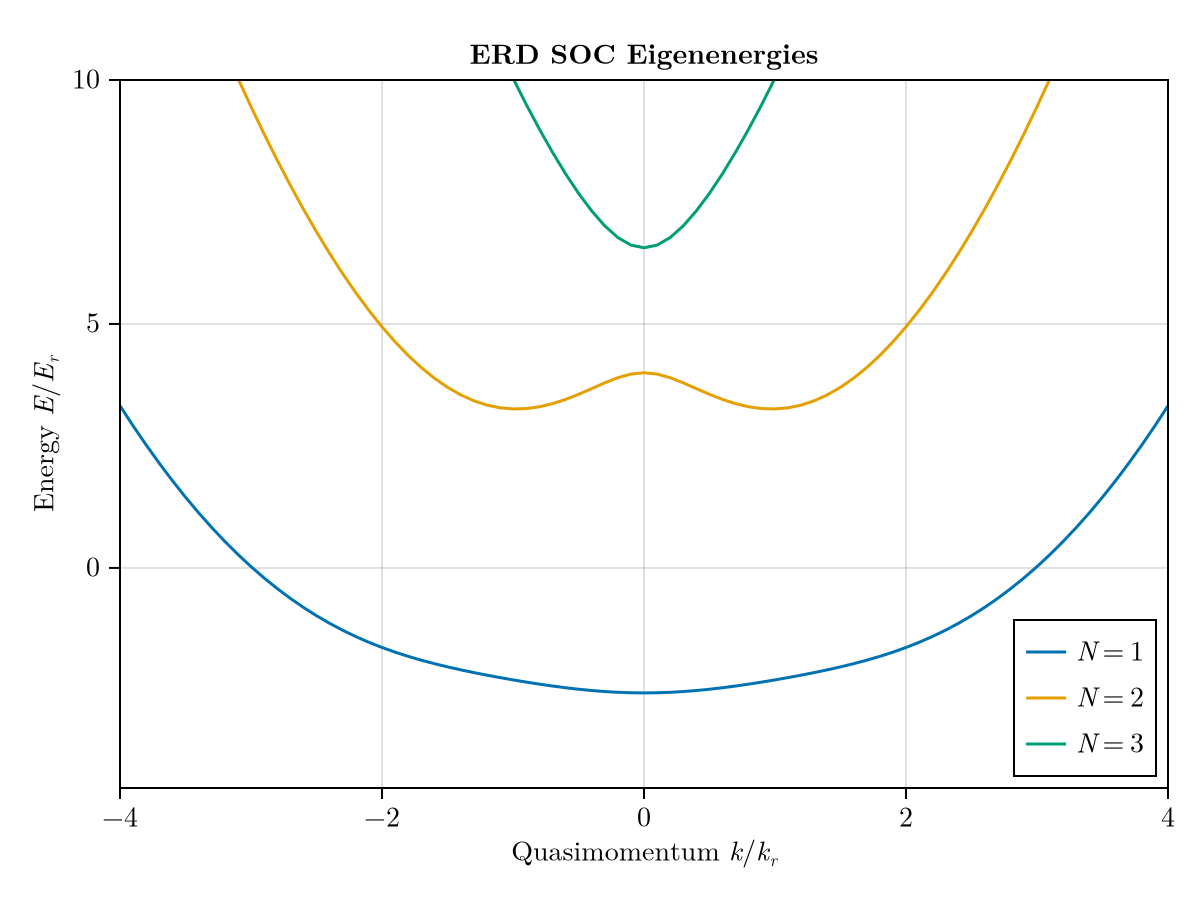

In [41]:
# Start with the dimensions for F = 1 to define the allowed spin states
dims = Dimensions(
    DimensionWithSpace(; x0=-1.0, dx=1.0, npnts=3, unit="Spin", periodic=false, spatial=false),
)

solver = ERD_SOC_Solver(dims)

# Setup the k grid:
qgrid = -4:0.1:4

values = stack([eigenvalues(solver.mwrs; q=q, Ω=4.1im) for q in qgrid]; dims=1)

# Plot the result!
f = Figure()
ax = Axis(f[1, 1],
    title = "ERD SOC Eigenenergies",
    xlabel = L"Quasimomentum $k/k_r$",
    ylabel = L"Energy $E/E_r$",
)
for j in 1:3
    lines!(
        ax,
        qgrid,
        values[:,j],
        label = L"N=%$(j)",
    )
end
ylims!(nothing, 10)
xlims!(extrema(qgrid)...)

axislegend(position = :rb)
f

This is great, but the next thing to deploy will be the idea of reference matrices.  Also in thinking about this I have come to the conclusion that, unlike Python, it doesn't make sense to carry around the eigenvalue / vector information inside the solver structure, and instead define a suitable return type.

### Other examples

Here is a more general example for a dense matrix including performance profiling

In [43]:
dims = Dimensions(
    DimensionWithSpace(; x0=-10.0, dx=1.0, npnts=401, unit="X Momentum", periodic=true, spatial=true),
)

qms = QMSolver(Matrix{ComplexF64}, dims; num_states=6, wrap=Hermitian)

add_leaf!(qms, :tunneling)
add_leaf!(qms, :potential)
add_rule!(qms, :potential, ExplicitRule, Diagonal(4 .* ones(ComplexF64, 401)))

function ham_tunneling(x, y; J=1.0)
    return -J
end

add_rule!(qms, :tunneling, RelativeRule, ham_tunneling, [1,])
add_rule!(qms, :tunneling, RelativeRule, ham_tunneling, [-1,])
set_default_kwargs!(mwrs, :tunneling; J=1.0)

generate_builders!(qms)

eigensystem!(qms; J=2.0)
qms.eigenvalues

401-element Vector{ComplexF64}:
 1.9999999999999998 + 0.0im
 2.0002455059975506 + 0.0im
  2.000245505997551 + 0.0im
 2.0009819637170065 + 0.0im
  2.000981963717007 + 0.0im
  2.002209192353581 + 0.0im
 2.0022091923535816 + 0.0im
 2.0039268906152836 + 0.0im
 2.0039268906152836 + 0.0im
 2.0061346367968893 + 0.0im
                    ⋮
  5.995030461226312 + 0.0im
 5.9969932436832485 + 0.0im
 5.9969932436832485 + 0.0im
  5.998465752321793 + 0.0im
  5.998465752321794 + 0.0im
  5.999447625632244 + 0.0im
  5.999447625632244 + 0.0im
 5.9999386225588145 + 0.0im
 5.9999386225588145 + 0.0im